# Basic visualisation of THAI LFRic simulations

### Synopsis

This notebook goes through the following steps:
1. Load LFRic output using `iris`, thus representing each of the output variables as `iris.cube.Cube`.
2. Regrid the cubes from unstructured grid to regular rectilinear lat-lon grid using `iris-esmf-regrid`.
3. Average the data over time and/or longitude using functions from `aeolus`.
4. Plot the results and save them to the `../plots/` directory.

Special thanks to Paul Earnshaw for the help with regridding LFRic output.

### Import the necessary libraries

Standard library

In [1]:
import warnings

warnings.filterwarnings("ignore")  # noqa

In [2]:
from functools import partial

In [3]:
from tqdm.notebook import tqdm

Scientific stack

In [4]:
import esmf_regrid
import iris
import iris.coord_systems
import iris.fileformats
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.colors as mcol
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import numpy as np
from esmf_regrid.experimental.unstructured_scheme import (
    MeshToGridESMFRegridder,
    regrid_unstructured_to_rectilinear,
)
from iris.experimental.ugrid import PARSE_UGRID_ON_LOAD

# from iris.experimental import stratify
from matplotlib.offsetbox import AnchoredText

In [5]:
from tqdm.notebook import tqdm

aeolus

In [6]:
import aeolus
from aeolus.calc import spatial_mean, time_mean, zonal_mean
from aeolus.const import init_const
from aeolus.coord import get_cube_rel_days, get_xy_coords, roll_cube_pm180
from aeolus.io import create_dummy_cube, load_vert_lev
from aeolus.model import um
from aeolus.plot import subplot_label_generator
from aeolus.subset import extract_last_n_days

In [7]:
print(iris.__version__, esmf_regrid.__version__, aeolus.__version__)

3.2.1 0.4.0 0.4.13+24.g3704b66


In [8]:
from pouch.plot import (
    KW_AUX_TTL,
    KW_MAIN_TTL,
    KW_SBPLT_LABEL,
    KW_ZERO_LINE,
    figsave,
    linspace_pm1,
    use_style,
)

local scripts

In [9]:
import mypaths
from lfric_util import clean_attrs  # add_equally_spaced_height_coord

In [10]:
def lfric_spatial_mean(cube, model=um):
    cube_copy = cube.copy()
    tmp_coord = iris.coords.AuxCoord(
        points=np.arange(cube.coord(model.x).shape[0]), long_name="mesh_coordinates"
    )

    cube_copy.add_aux_coord(tmp_coord, data_dims=cube.coord_dims(model.x))

    cube_copy.remove_coord(model.x)
    cube_copy.remove_coord(model.y)

    cube_mean = cube_copy.collapsed(tmp_coord.name(), iris.analysis.MEAN)
    cube_mean.remove_coord(tmp_coord)
    return cube_mean


def broadcast_cube(cube, target_cube, **kwargs):
    """Broadcast cube to the shape of another cube with at least 1 matching dimension."""
    kw = {
        "units": cube.units,
        "long_name": cube.long_name,
        "standard_name": cube.standard_name,
        "var_name": cube.var_name,
    }
    kw = {**kw, **kwargs}
    data_bcast = iris.util.broadcast_to_shape(
        cube.data,
        target_cube.shape,
        dim_map=[target_cube.coord_dims(coord)[0] for coord in cube.dim_coords],
    )
    tgt_dim_coords = [
        (c.copy(), target_cube.coord_dims(c)) for c in target_cube.dim_coords
    ]
    tgt_aux_coords = [
        (c.copy(), target_cube.coord_dims(c)) for c in target_cube.aux_coords
    ]
    cube_bcast = iris.cube.Cube(
        data=data_bcast,
        dim_coords_and_dims=tgt_dim_coords,
        aux_coords_and_dims=tgt_aux_coords,
        **kw,
    )
    return cube_bcast

### Some global definitions

Apply a custom `matplotlib` style.

In [11]:
use_style()

Create a path effects object to highlight contours for later

In [12]:
PE = [PathEffects.withStroke(linewidth=0.5, foreground="w")]

Select the run configuration

In [13]:
planet = "ben1"
SIM_LABEL = "THAI Ben 1"
const = init_const(planet, directory=mypaths.const)

In [14]:
kappa = const.dry_air_gas_constant / const.dry_air_spec_heat_press

Common directory where to save plots.

In [15]:
plot_dir = mypaths.plot

### Load the data into a cube list

Use a callback function to attach a level height coordinate for convenience.

Note: adapt the file path to the one on your machine in the `mypaths.py` script.

In [16]:
vert_lev = load_vert_lev(mypaths.vert_um / "vertlevs_L38_29t_9s_40km")

In [17]:
SENS_LABELS = {
    "base": {
        "title": "Base\n(smagorinsky=.false.)",
    },
    "smag_0p2_blend": {
        "title": "smagorinsky=.true.\nmethod='blending'\nmix_factor=0.2",
    },
}

In [18]:
sim_case = "ben1"
timestep = 1800
# sim_case = "ben2"
# timestep = 300
with_restart = False
rundir = f"run_lfric_atm_thai_{sim_case}{'with_restart' if with_restart else '_'}C24_dt-{timestep}p0_intel_64-bit_fast-debug"

In [19]:
runs = {}
for sens_label in tqdm(SENS_LABELS.keys()):
    fnames = [
        str(i)
        for i in sorted(
            (mypaths.results_lfric / "thai" / sim_case).glob(
                f"{sens_label}/*/{rundir}/lfric_diag.nc"
            ),
            key=lambda x: int(x.parent.parent.name),
        )
    ]
    fnames = fnames[6:16]
    with PARSE_UGRID_ON_LOAD.context():
        cl_no_callback = iris.load(fnames)

        for cube in cl_no_callback:
            try:
                cube.attributes.pop("timeStamp")
                cube.attributes.pop("uuid")
            except KeyError:
                pass
        runs[sens_label] = cl_no_callback.concatenate(check_aux_coords=False)

  0%|          | 0/2 [00:00<?, ?it/s]

15-03-2022 15:35:10 iris.experimental.ugrid.load WARNING - *Assuming* 'topology_dimension'=1, from the attached connectivities of the mesh variable Mesh2d_edge.  However, Mesh2d_edge:topology_dimension = 2 -- ignoring this as it is inconsistent. [None._build_mesh]
15-03-2022 15:35:10 iris.experimental.ugrid.load WARNING - *Assuming* 'topology_dimension'=1, from the attached connectivities of the mesh variable Mesh2d_edge.  However, Mesh2d_edge:topology_dimension = 2 -- ignoring this as it is inconsistent. [None._build_mesh]
15-03-2022 15:35:11 iris.experimental.ugrid.load WARNING - *Assuming* 'topology_dimension'=1, from the attached connectivities of the mesh variable Mesh2d_edge.  However, Mesh2d_edge:topology_dimension = 2 -- ignoring this as it is inconsistent. [None._build_mesh]
15-03-2022 15:35:11 iris.experimental.ugrid.load WARNING - *Assuming* 'topology_dimension'=1, from the attached connectivities of the mesh variable Mesh2d_edge.  However, Mesh2d_edge:topology_dimension = 2

In [20]:
tgt_cube = create_dummy_cube(
    nlat=90, nlon=144, pm180=True
)  # Use a non-standard number of points to match UoE SA suites

In [21]:
RESULTS = {}
for sens_label in tqdm(SENS_LABELS.keys()):
    RESULTS[sens_label] = {}
    u_w3 = runs[sens_label].extract_cube(
        iris.Constraint(cube_func=lambda cube: cube.var_name == "u1_in_w3")
    )
    u_w3_tm = time_mean(u_w3)

    exner = runs[sens_label].extract_cube(
        iris.Constraint(cube_func=lambda cube: cube.var_name == "exner")
    )

    pres = exner.copy(
        data=const.reference_surface_pressure.data * (exner.data ** (1 / kappa.data))
    )
    pres.rename("air_pressure")
    pres.units = "Pa"
    pres_tm = time_mean(pres)

    RESULTS[sens_label]["u"] = regrid_unstructured_to_rectilinear(u_w3_tm, tgt_cube)
    RESULTS[sens_label]["pres"] = regrid_unstructured_to_rectilinear(pres_tm, tgt_cube)

  0%|          | 0/2 [00:00<?, ?it/s]

Saved to ../plots/lfric_atm_thai_ben1_C24_dt-1800p0__base_smag_0p2_blend__u1_in_w3__tzm.png


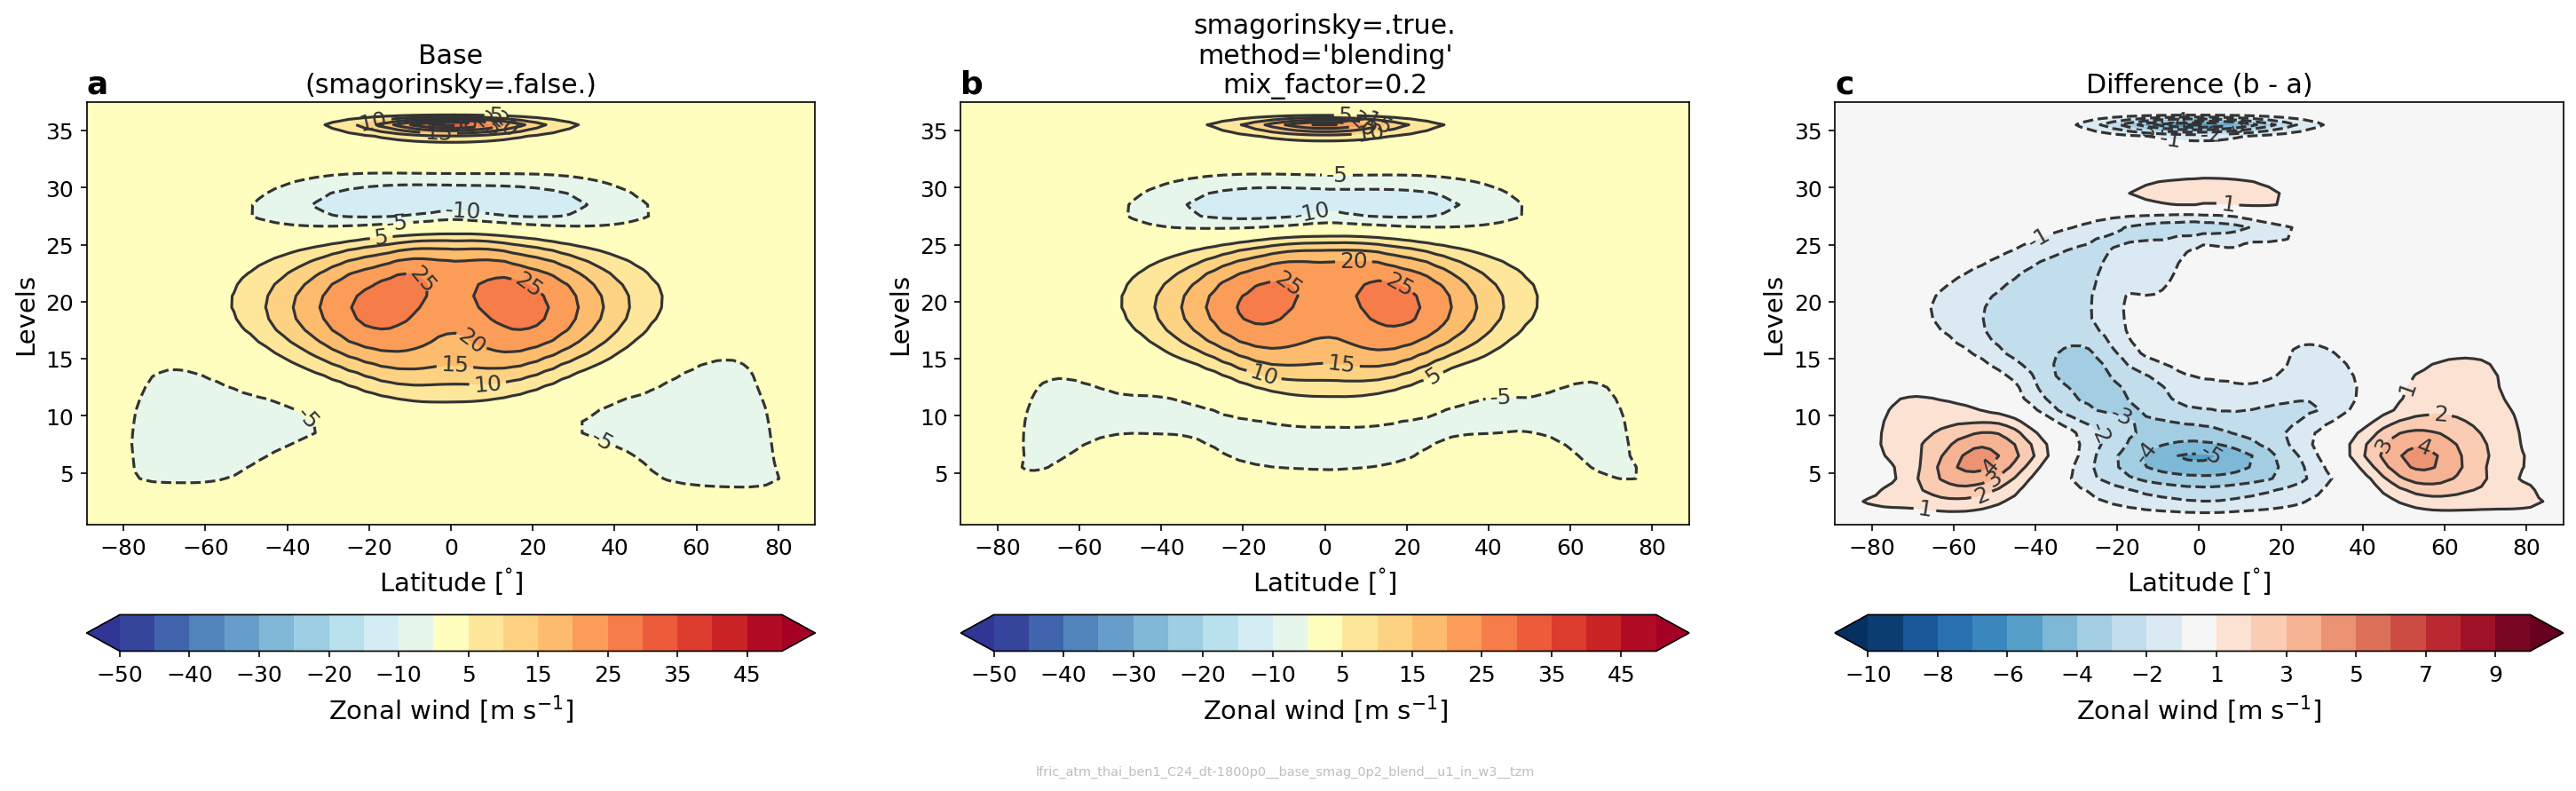

In [22]:
ncols = len(RESULTS) + 1
nrows = 1

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8 * ncols, 6 * nrows))
iletters = subplot_label_generator()
for ax in axs.flat:
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
    # ax.set_yscale("log")
    # ax.set_ylim(1000, 1)
    # ax.set_yticks([1000, 100, 10, 1])
    # ax.set_yticklabels([1000, 100, 10, 1])
    # ax.set_ylabel("Pressure [$hPa$]")
    ax.set_ylabel("Levels")
    ax.set_xlabel("Latitude [$^\degree$]")

for (sens_label, sens_opt), ax in zip(SENS_LABELS.items(), axs.flat):
    ax.set_title(sens_opt["title"], **KW_MAIN_TTL)

    cube = zonal_mean(RESULTS[sens_label]["u"])
    lats = cube.coord("latitude").points
    pres_hpa = spatial_mean(RESULTS[sens_label]["pres"]).data * 1e-2

    p0 = ax.contourf(
        lats,
        cube.coord("half_levels").points,
        cube.data,
        cmap="RdYlBu_r",
        levels=linspace_pm1(10) * 50,
        extend="both",
    )
    p1 = ax.contour(
        lats,
        cube.coord("half_levels").points,
        cube.data,
        colors="#333333",
        levels=linspace_pm1(10) * 50,
    )
    ax.clabel(p1, fmt="%.0f", colors="#333333")
    cbar = fig.colorbar(p0, ax=ax, orientation="horizontal")
    cbar.ax.set_xlabel("Zonal wind [$m$ $s^{-1}$]")

ax = axs[-1]
ax.set_title("Difference (b - a)", **KW_MAIN_TTL)
cube = zonal_mean(RESULTS["smag_0p2_blend"]["u"]) - zonal_mean(RESULTS["base"]["u"])
p0 = ax.contourf(
    lats,
    cube.coord("half_levels").points,
    cube.data,
    cmap="RdBu_r",
    levels=linspace_pm1(10) * 10,
    extend="both",
)
p1 = ax.contour(
    lats,
    cube.coord("half_levels").points,
    cube.data,
    colors="#333333",
    levels=linspace_pm1(10) * 10,
)
ax.clabel(p1, fmt="%.0f", colors="#333333")
cbar = fig.colorbar(p0, ax=ax, orientation="horizontal")
cbar.ax.set_xlabel("Zonal wind [$m$ $s^{-1}$]")

figsave(
    fig,
    plot_dir
    / f"lfric_atm_thai_{sim_case}_C24_dt-{timestep}p0__{'_'.join(SENS_LABELS.keys())}__{RESULTS[sens_label]['u'].var_name}__tzm",
)